**решающее дерево, регрессия**

Евгений Борисов <esborisov@sevsu.ru>

---

Yury Kashnitsky   Классификация, деревья решений и метод ближайших соседей   
https://habr.com/ru/companies/ods/articles/322534/

# генерируем набор данных

In [1]:
import numpy as np
import numpy.random as rng
from matplotlib import pyplot as plt

np.set_printoptions(precision=2)

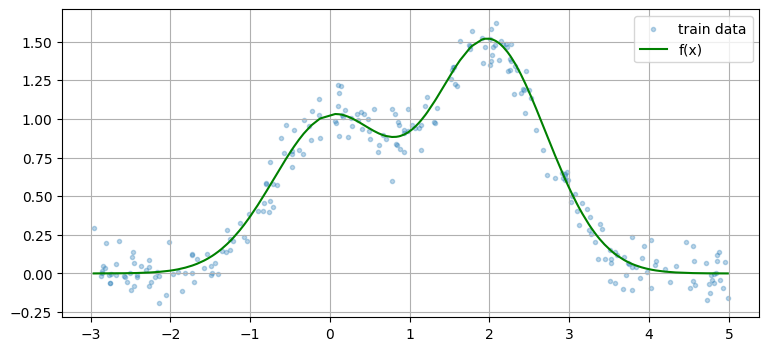

In [2]:
# f,xlim = (lambda x: np.sin(x*2.9)),(-1.,+2.)
# f,xlim = lambda x: np.sin(x*2.9)+np.cos(x*5.9),(-1,1)
f,xlim = lambda x: np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2), (-3,5)

def generate(f, xlim=(-1.,1.), n_samples=256, noise=.1 ):
    assert len(xlim)==2
    assert xlim[0]<xlim[1]
    assert n_samples>2
    assert 0.<noise<1.
    x = np.sort( rng.rand(n_samples)*(xlim[1]-xlim[0]) + xlim[0] )
    return x.reshape(-1,1), ( f(x)+rng.normal(0.,noise,n_samples) ).reshape(-1,1)

X_train,y_train = generate(f=f,xlim=xlim)

# рисуем результат
fig,ax = plt.subplots(figsize=(9,4))
ax.scatter(x=X_train,y=y_train,alpha=.3,marker='.',label='train data') # точки учебного набора
ax.plot(X_train,f(X_train),c='g',label='f(x)')
ax.grid()
ax.legend()

## критерий 

подбираем признак $x_j$ и порог его значений $b$, который бы  минимизировал дисперсию значений $y$ в разбиении $x_j>b$

$$\Large D = \frac{1}{\ell} \sum\limits_{i =1}^{\ell} (y_i - \frac{1}{\ell} \sum\limits_{i =1}^{\ell} y_i)^2, $$

где $\ell$ – число объектов в разбиении $x_j>b$  

таким образом - значения $y$ в каждом листе будут примерно равны.



In [3]:
class StdCriterion:
    
    def score(self,x,b,y):
        assert len(x)>0
        assert len(x)==len(y)
        f=x>b
        return ( y[f].std() +y [~f].std() ) / 2.

In [4]:
StdCriterion().score( x=X_train[:,0], b=X_train[:,0].mean(), y=y_train)

0.5180636710546944

## строим модель

In [5]:
class DecisionTreeRegressor:
    
    def __init__(self, info_crit=StdCriterion()):
        self._info_crit = info_crit
        self._tree = dict()
        self._rules = []
        self._values = np.array([])
    
    def fit(self,X,y,nb=32,min_split_sample=2): 
        self._tree = self._id3(X,y,nb=nb,min_split_sample=min_split_sample)
        rules = self._tree2rules(self._tree)            
        self._rules = [ r[0] for r in rules ]
        self._values = np.array([ r[1] for r in rules ])
        return self
        
        
    def _id3(self,X,y,nb,min_split_sample): # строим решающее дерево
        if len(y)<min_split_sample: # минимальное количество точек в разбиении
            return { # то создаём лист с меткой класса
                'value':y.mean() # номер класса в листе дерева
            } 
        i,b,si = self._search_split(X,y,nb=nb) # ищем оптимальное разделение по признаку
        f = X[:,i]>b # метки разбиения для датасета X (помечаем примеры, которые выделяет предикат)
        return {  # создаём узел дерева
            'feature':i, # номер признака для применения порога
            'threshold':b, # порог разбиения для признака
            'info':si, # информативность разбиения
            '<': self._id3(X[~f,:],y[~f],nb=nb,min_split_sample=min_split_sample), # разбиваем датасет ...
            '>': self._id3(X[f,:],y[f],nb=nb,min_split_sample=min_split_sample)   # ... и повторяем рекурсивно для двух частей
        }

    # поиск оптимальной гиперплоскости 
    def _search_split(self,X,y,nb): # np - количество порогов для перебора
        # min и max для каждого признака
        mm = np.vstack([X.min(axis=0), X.max(axis=0),]).T
        # список порогов для каждого признака
        b = np.linspace( start=mm[:,0], stop=mm[:,1], num=nb+2 )[1:-1,:]

        # значение информативности для каждого признака и порога 
        split_inf = np.array([ 
                [ self._info_crit.score(X[:,i],b[j,i],y) for i in range(X.shape[1])  ]
                for j in range(nb) 
            ])

        # индексы максимального значения в матрице информативности
        j,i = np.unravel_index(split_inf.argmin(),split_inf.shape)

        # результаты - параметры разбиения с максимальной информативностью
        return (
            i, # номер признака
            b[j,i], # порог
            split_inf[j,i], # значение информативности 
        )
    
    @property
    def tree(self): return self._tree
         
    def predict(self,x): 
        idx = np.argmax(np.vstack([ r(x) for r in self._rules ]).T,axis=1)
        return self._values[idx]
    

    # конвертируем дерево в предикаты 
    @classmethod
    def _tree2rules(cls,node,result=[],rule=[],condition=None):
        if not(condition is None): # если пороговое условие не пустое
            rule.append( condition ) #  то докидываем его в правило

        if 'value' in node:
            # выполняем конъюнкцию всех условий ...
            result.append( [ cls._conditions_and(rule), node['value'] ] ) # ... и докидываем правило в список дизъюнктов
            return result

        cls._tree2rules( # двигаемся в ветку '>'
            node=node['>'],
            result=result,
            rule=rule.copy(),
            condition=lambda x: x[ :,node['feature'] ]>node['threshold'] # создаём пороговое правило
        )

        cls._tree2rules( # двигаемся в ветку '<'
            node=node['<'],
            result=result,
            rule=rule.copy(),
            condition=lambda x: x[ :,node['feature'] ]<node['threshold'] # создаём пороговое правило
        )
        return result


    @staticmethod
    def _conditions_and(rule): # конъюнкция пороговых условий (одна ветка дерева от корня к листу positive)
        return lambda x: np.vstack([ condition(x) for condition in rule ]).all(axis=0)


## обучаем 

In [6]:
model = DecisionTreeRegressor().fit(X_train,y_train,min_split_sample=32)

### визуализация дерева

In [7]:
# display( model.tree )

In [8]:
from collections import Counter
import graphviz

class DecisionTreePlotter:

    @classmethod
    def transform(self,tree,size='11,11'):
        dot = graphviz.Digraph()
        dot.attr(size=size)
        dot.node('root','start',color='yellow',style='filled')
        return self._plot_tree(tree,dot)

    @classmethod
    def _plot_tree(self,root,dot,dot_root='root',nc=Counter('id'),is_true=True):
        nc['id']+=1
        dot_node='node{id}'.format(**nc)
        if 'feature' in root:
            label = r'x[{feature}]>{threshold:.3f}\rinfo:{info:.3f}'.format(**root)
            dot.node(dot_node,label,color='lightgray',style='filled')
            self._plot_tree(root=root['>'], dot=dot, dot_root=dot_node, nc=nc, is_true=True)
            self._plot_tree(root=root['<'], dot=dot, dot_root=dot_node, nc=nc, is_true=False)
        else:
            label = '{value:.3f}'.format(**root)
            dot.node(dot_node,label,color='lightskyblue',style='filled')
            
        dot.edge(dot_root,dot_node,color=('green' if is_true else 'red'))
        
        return dot 

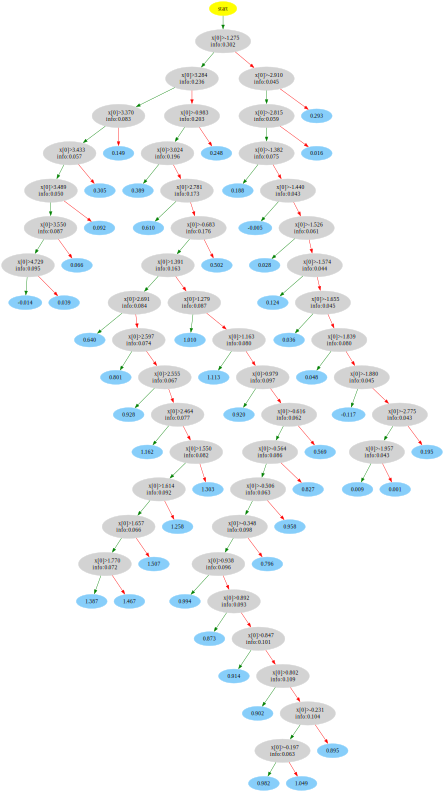

In [9]:
DecisionTreePlotter().transform(model.tree)

## тестируем

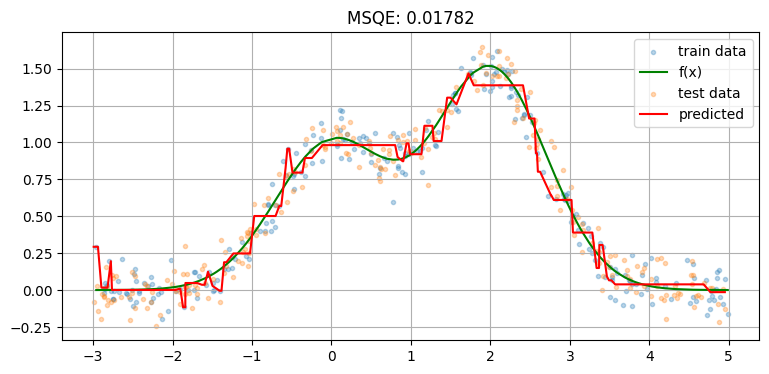

In [10]:
X_test,y_test = generate(f=f,xlim=xlim)

predicted = model.predict(X_test)

from sklearn.metrics import mean_squared_error

# рисуем результат
fig,ax = plt.subplots(figsize=(9,4))
ax.scatter(x=X_train,y=y_train,alpha=.3,marker='.',label='train data') # точки учебного набора
ax.plot(X_train,f(X_train),c='g',label='f(x)')
ax.scatter(x=X_test,y=y_test,alpha=.3,marker='.',label='test data') # точки учебного набора
ax.plot(X_test,predicted,c='r',label='predicted')
ax.set_title(f'MSQE: {mean_squared_error(y_true=y_test,y_pred=predicted):.5f}')
# ax.set_xlim(X_test.min()-.1,X_test.max()+.1)
ax.set_ylim(y_test.min()-.1,y_test.max()+.1)
ax.grid()
ax.legend()